In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

,Extent,Date
0,1090625.815,1979-01-01
1,1157634.866,1979-02-01
2,1299583.477,1979-03-01
3,1137194.680,1979-04-01
4,983083.453,1979-05-01
...,...,...
533,781460.891,2023-06-01
534,331845.048,2023-07-01
535,99334.625,2023-08-01
536,49359.723,2023-09-01


In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 23s 255ms/step - loss: 0.2369 - root_mean_squared_error: 0.4867 - val_loss: 0.1655 - val_root_mean_squared_error: 0.4068
Epoch 2/50
53/53 [==============================] - 12s 236ms/step - loss: 0.1467 - root_mean_squared_error: 0.3831 - val_loss: 0.0906 - val_root_mean_squared_error: 0.3011
Epoch 3/50
53/53 [==============================] - 12s 226ms/step - loss: 0.0903 - root_mean_squared_error: 0.3005 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2871
Epoch 4/50
53/53 [==============================] - 13s 250ms/step - loss: 0.0804 - root_mean_squared_error: 0.2835 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2708
Epoch 5/50
53/53 [==============================] - 13s 251ms/step - loss: 0.0706 - root_mean_squared_error: 0.2658 - val_loss: 0.0645 - val_root_mean_squared_error: 0.2539
Epoch 6/50
53/53 [==============================] - 11s 204ms/step - loss: 0.0558 - root_mean_squared_error: 0.2362 - val_loss: 0.0413 

Epoch 35/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 36/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 37/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 38/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 39/50
53/53 [==============================] - 2s 29ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 40/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0037 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.186088208357493 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

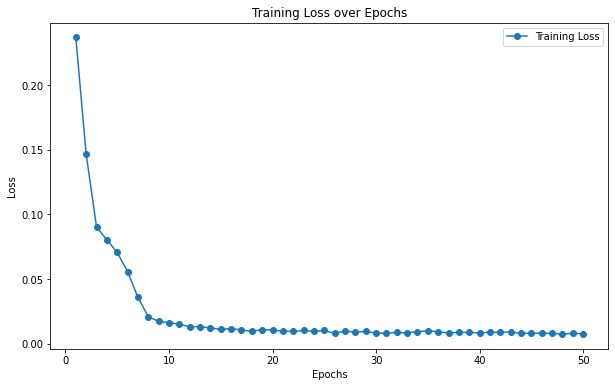

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

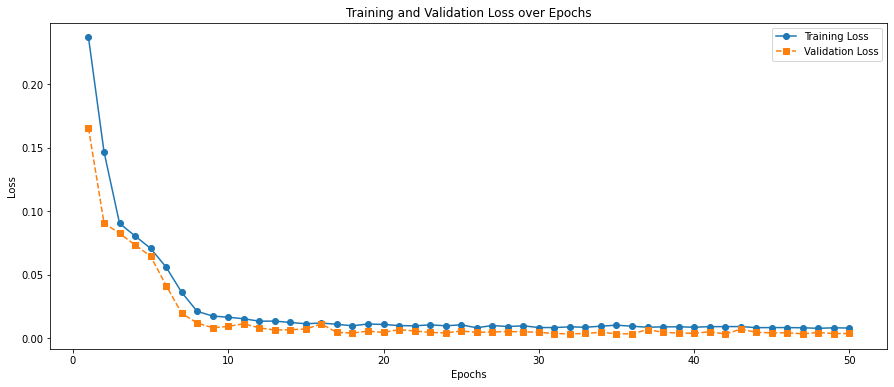

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 9ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.056438675745298046
MAE : 0.04473860179340796


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,8.249596e+05,678576.504
1,1.081849e+06,974461.347
2,1.219176e+06,1181121.087
3,1.207165e+06,1236299.254
4,1.076366e+06,1036981.003
5,8.499776e+05,847489.150
6,5.265753e+05,619129.338
7,2.615043e+05,195688.491
8,9.158030e+04,36670.811
9,2.131875e+04,31777.310


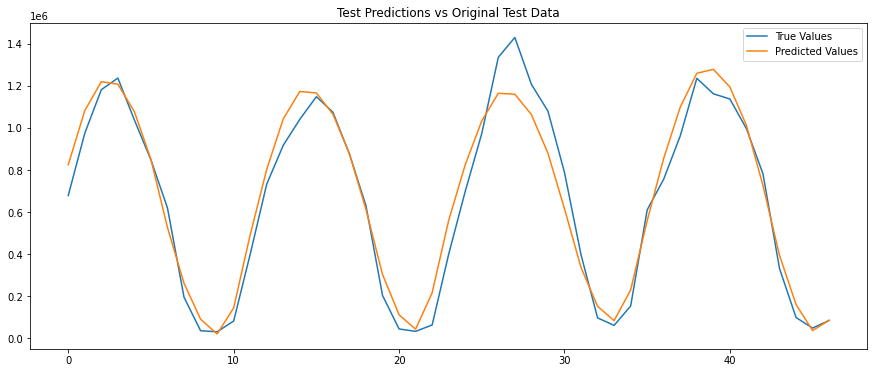

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

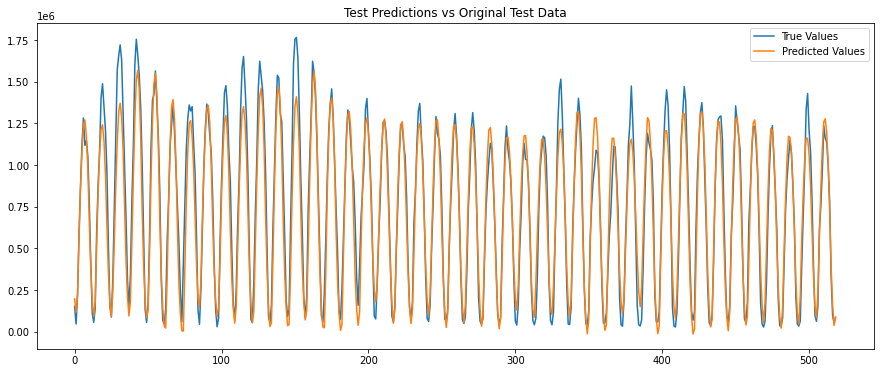

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()